Using device: cuda
Original dataset shape: (422746, 2)
Sampled dataset shape: (84549, 2)
Emotions: ['joy' 'fear' 'sad' 'anger' 'suprise' 'love']
Number of unique emotions: 6


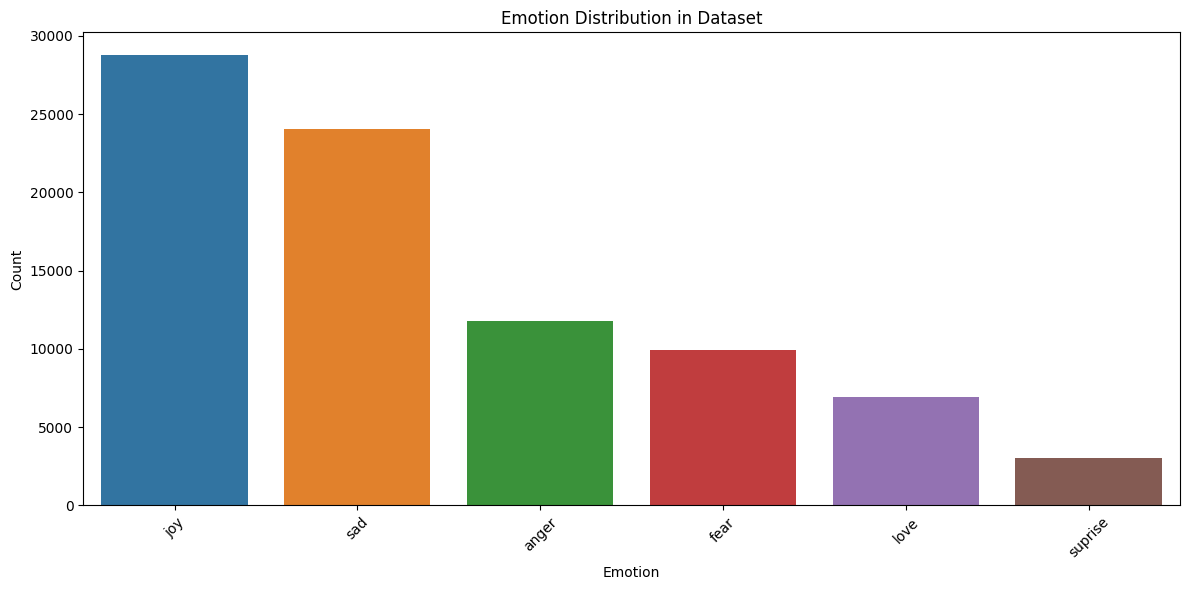

Training set size: 59184
Validation set size: 8455
Test set size: 16910


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training...
==================== Epoch 1/2 ====================


Training: 100%|██████████| 500/500 [01:00<00:00,  8.23it/s, loss=0.193, acc=0.848, batch_time=0.042s]


Average training loss: 0.436
Training accuracy: 0.848
Average batch processing time: 0.044 seconds
Evaluating on validation set...


Evaluating:  38%|███▊      | 100/265 [00:04<00:07, 21.03it/s]


Validation Loss: 0.197
Validation Accuracy: 0.9244
New best model saved!
Epoch 1 completed in 65.95 seconds
==================== Epoch 2/2 ====================


Training: 100%|██████████| 500/500 [00:59<00:00,  8.34it/s, loss=0.086, acc=0.927, batch_time=0.042s]


Average training loss: 0.170
Training accuracy: 0.927
Average batch processing time: 0.042 seconds
Evaluating on validation set...


Evaluating:  38%|███▊      | 100/265 [00:04<00:07, 21.07it/s]


Validation Loss: 0.126
Validation Accuracy: 0.9381
New best model saved!
Epoch 2 completed in 65.40 seconds


<ipython-input-1-54c4dabcf547>:322: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_emotion_model.pt'))


Loaded best model for final evaluation
Evaluating on test set...


Evaluating: 100%|██████████| 529/529 [00:25<00:00, 21.05it/s]


Test Loss: 0.129
Test Accuracy: 0.9357

Classification Report:
              precision    recall  f1-score   support

         joy      0.980     0.928     0.953      5756
        fear      0.915     0.882     0.898      1990
         sad      0.952     0.983     0.967      4807
       anger      0.976     0.901     0.937      2362
     suprise      0.792     0.826     0.809       609
        love      0.777     0.986     0.869      1386

    accuracy                          0.936     16910
   macro avg      0.899     0.918     0.906     16910
weighted avg      0.940     0.936     0.936     16910

Total training time: 164.71 seconds


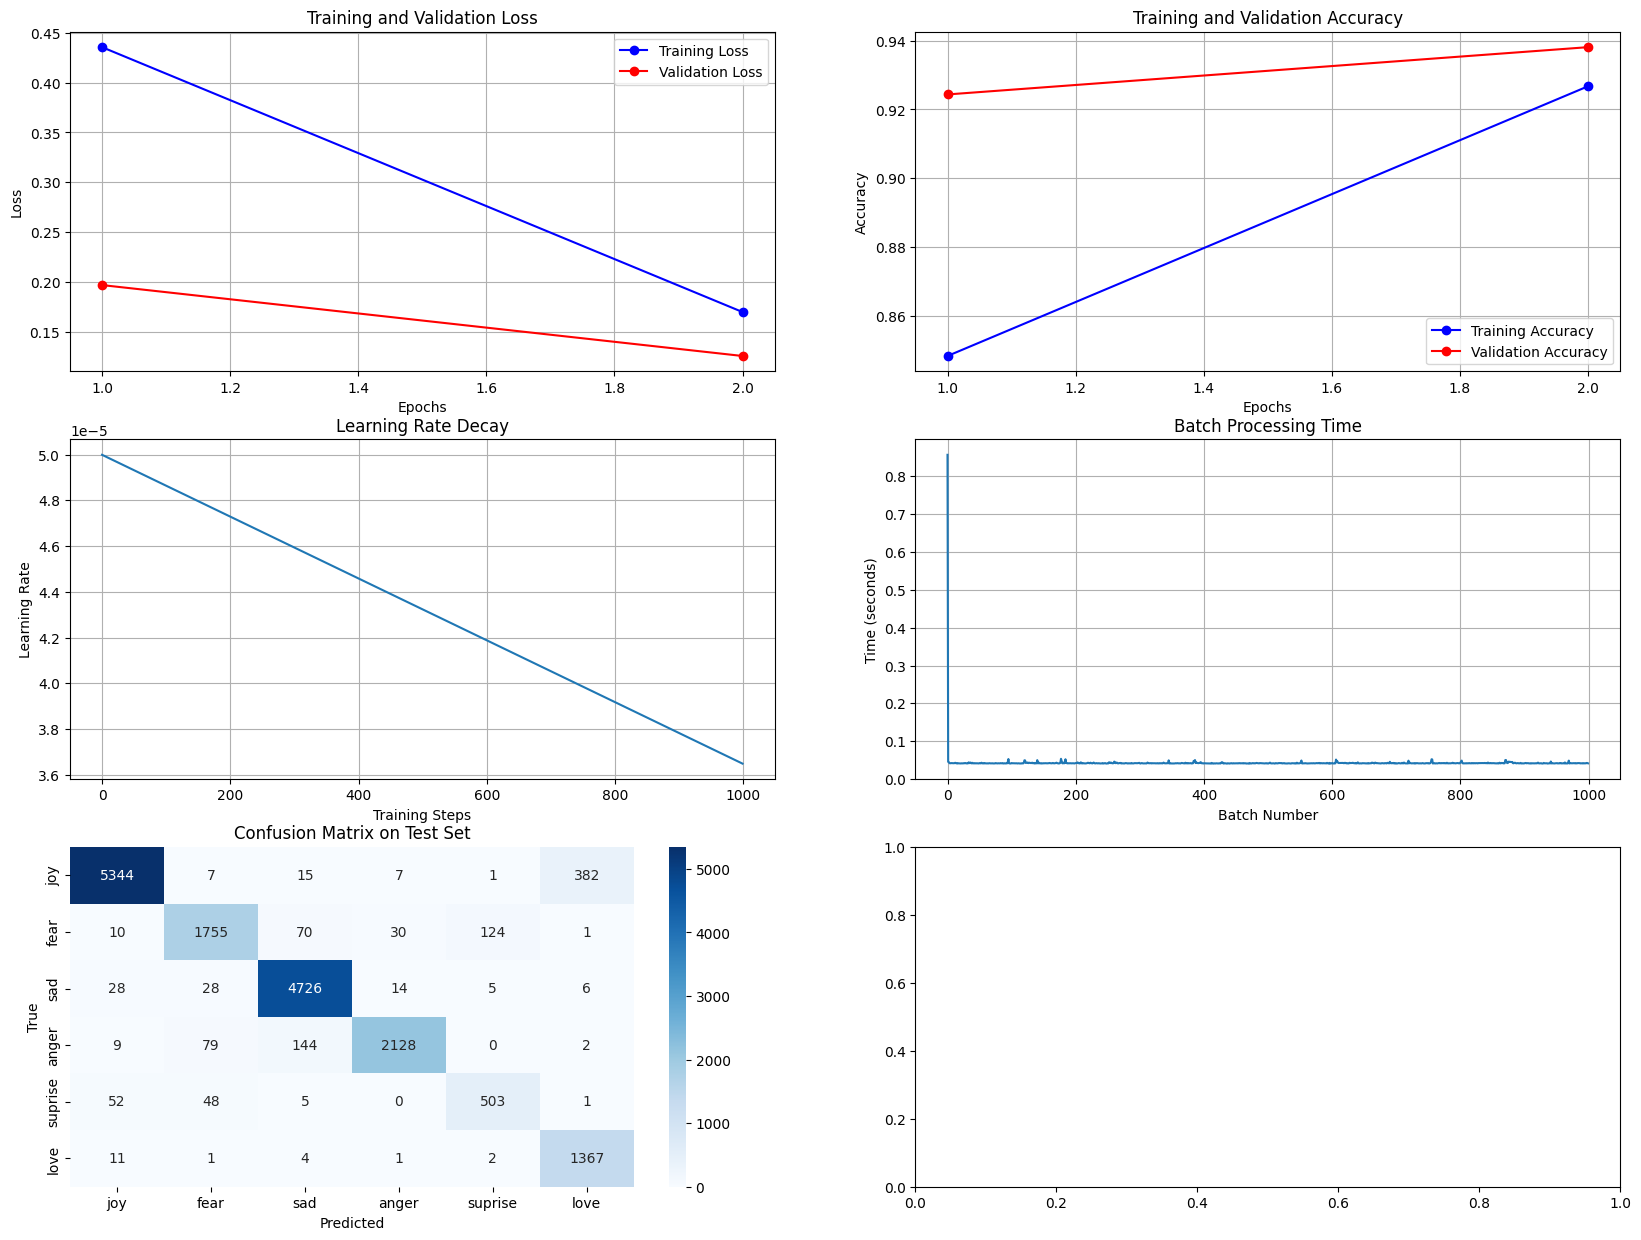

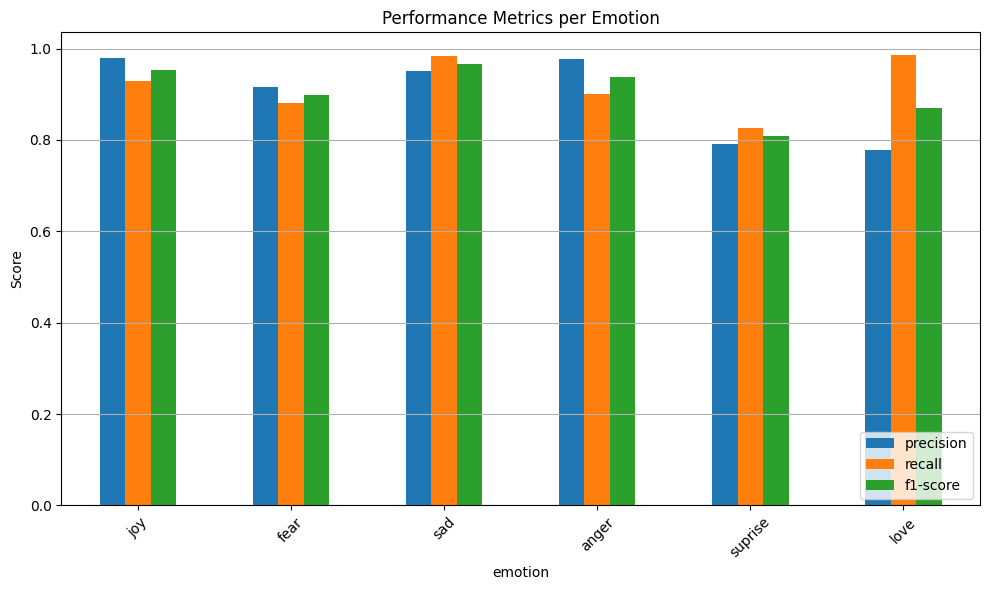


Prediction examples:
Sentence: 'I'm so happy today!'
Predicted emotion: joy (confidence: 99.90%)

Sentence: 'This is frustrating me a lot.'
Predicted emotion: sad (confidence: 59.72%)

Sentence: 'I'm feeling very calm and peaceful.'
Predicted emotion: joy (confidence: 99.91%)

Sentence: 'That news made me really angry.'
Predicted emotion: anger (confidence: 99.52%)



In [1]:
# BERT for Emotion Classification (Optimized for faster training with visualization)
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, DistilBertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Start timing
start_time = time.time()

# Load dataset 
df = pd.read_csv('/kaggle/input/combined-4lac-dataset/combined_emotion.csv')
print(f"Original dataset shape: {df.shape}")

# OPTIMIZATION 1: Use a smaller subset of data for faster training
# Using 20% of data for training to significantly reduce training time
sample_size = int(0.2 * len(df))  # Use 20% of the data
df = df.sample(n=sample_size, random_state=seed)
print(f"Sampled dataset shape: {df.shape}")

# Convert emotions to numerical labels
emotions = df['emotion'].unique()
emotion_to_id = {emotion: idx for idx, emotion in enumerate(emotions)}
id_to_emotion = {idx: emotion for idx, emotion in enumerate(emotions)}
num_labels = len(emotions)

print(f"Emotions: {emotions}")
print(f"Number of unique emotions: {num_labels}")

# Plot emotion distribution
plt.figure(figsize=(12, 6))
emotion_counts = df['emotion'].value_counts()
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Emotion Distribution in Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('emotion_distribution.png')
plt.show()

# Split dataset into train and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['emotion'])
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=seed, stratify=train_df['emotion'])
# This gives approximately 70% train, 10% validation, 20% test

print(f"Training set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")

# Create dataset class with shorter sequence length
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):  # OPTIMIZATION 2: Reduced from 128 to 64
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets and dataloaders
train_texts = train_df['sentence'].values
train_labels = train_df['emotion'].map(emotion_to_id).values

val_texts = val_df['sentence'].values
val_labels = val_df['emotion'].map(emotion_to_id).values

test_texts = test_df['sentence'].values
test_labels = test_df['emotion'].map(emotion_to_id).values

# Create datasets
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer)

# OPTIMIZATION 4: Increase batch size if your GPU allows it
batch_size = 32  # Increased from 16 to 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# OPTIMIZATION 5: Use DistilBERT instead of BERT (smaller and faster model)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

# OPTIMIZATION 6: Use slightly higher learning rate for faster convergence
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)  # Increased from 2e-5 to 5e-5

# OPTIMIZATION 7: Reduce number of training epochs
epochs = 2  # Reduced from 4 to 2

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Set up learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lr_rates = []
batch_times = []

# Define training function with early stopping check
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    batch_time_sum = 0
    
    # OPTIMIZATION 8: Limit the number of batches per epoch for even faster training
    # This is optional - comment out the next line if you want to use all batches
    max_batches = min(500, len(dataloader))  # Process at most 500 batches per epoch
    
    progress_bar = tqdm(enumerate(dataloader), total=max_batches, desc="Training", position=0, leave=True)
    
    for i, batch in progress_bar:
        if i >= max_batches:
            break
            
        batch_start = time.time()
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        # Calculate accuracy for this batch
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += len(labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        # Track learning rate
        lr_rates.append(scheduler.get_last_lr()[0])
        
        # Track batch processing time
        batch_end = time.time()
        batch_time = batch_end - batch_start
        batch_times.append(batch_time)
        batch_time_sum += batch_time
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'acc': f'{correct_predictions/total_predictions:.3f}',
            'batch_time': f'{batch_time:.3f}s'
        })
    
    avg_loss = total_loss / min(max_batches, len(dataloader))
    avg_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    avg_batch_time = batch_time_sum / min(max_batches, len(dataloader))
    
    return avg_loss, avg_accuracy, avg_batch_time

# Define evaluation function
# Fix for the evaluate function to handle None properly
def evaluate(model, dataloader, device, max_eval_batches=100):
    model.eval()
    total_loss = 0
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="Evaluating")):
            # Skip the break condition if max_eval_batches is None
            if max_eval_batches is not None and i >= max_eval_batches:
                break
                
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    
    # Avoid division by zero if dataloader is empty
    n_batches = min(max_eval_batches, len(dataloader)) if max_eval_batches is not None else len(dataloader)
    avg_loss = total_loss / max(1, n_batches)
    accuracy = accuracy_score(actual_labels, predictions)
    
    return avg_loss, accuracy, predictions, actual_labels

# Training loop with early stopping
training_stats = []
best_accuracy = 0
patience = 2  # OPTIMIZATION 11: Early stopping
patience_counter = 0

print("Starting training...")
for epoch in range(epochs):
    epoch_start = time.time()
    print(f"{'='*20} Epoch {epoch+1}/{epochs} {'='*20}")
    
    # Train
    train_loss, train_accuracy, avg_batch_time = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    print(f"Average training loss: {train_loss:.3f}")
    print(f"Training accuracy: {train_accuracy:.3f}")
    print(f"Average batch processing time: {avg_batch_time:.3f} seconds")
    
    # Evaluate
    print("Evaluating on validation set...")
    val_loss, val_accuracy, val_predictions, val_labels = evaluate(model, val_dataloader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Validation Loss: {val_loss:.3f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Early stopping check
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_emotion_model.pt')
        print("New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break
    
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    
    # Save stats for plotting
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'epoch_time': epoch_time
    })
    
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")

# Load the best model for final testing
model.load_state_dict(torch.load('best_emotion_model.pt'))
print("Loaded best model for final evaluation")

# Test on the held-out test set
print("Evaluating on test set...")
test_loss, test_accuracy, test_predictions, test_labels = evaluate(model, test_dataloader, device, max_eval_batches=None)  # Use all test data
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
test_report = classification_report(
    test_labels,
    test_predictions,
    target_names=[id_to_emotion[i] for i in range(num_labels)],
    digits=3
)
print(test_report)

# Calculate total training time
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

# Create comprehensive visualizations
plt.figure(figsize=(20, 15))

# 1. Training and Validation Loss
plt.subplot(3, 2, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss')
plt.plot(epochs_range, val_losses, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Training and Validation Accuracy
plt.subplot(3, 2, 2)
plt.plot(epochs_range, train_accuracies, 'b-o', label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 3. Learning Rate over Steps
plt.subplot(3, 2, 3)
plt.plot(range(len(lr_rates)), lr_rates)
plt.title('Learning Rate Decay')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.grid(True)

# 4. Batch Processing Time
plt.subplot(3, 2, 4)
plt.plot(range(len(batch_times)), batch_times)
plt.title('Batch Processing Time')
plt.xlabel('Batch Number')
plt.ylabel('Time (seconds)')
plt.grid(True)

# 5. Confusion Matrix
plt.subplot(3, 2, 5)
cm = confusion_matrix(test_labels, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_emotion[i] for i in range(num_labels)],
            yticklabels=[id_to_emotion[i] for i in range(num_labels)])
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')

# 6. Performance per Emotion
plt.subplot(3, 2, 6)
report_dict = classification_report(test_labels, test_predictions, 
                                    target_names=[id_to_emotion[i] for i in range(num_labels)],
                                    output_dict=True)
performances = []
for emotion in [id_to_emotion[i] for i in range(num_labels)]:
    if emotion in report_dict:
        performances.append({
            'emotion': emotion,
            'precision': report_dict[emotion]['precision'],
            'recall': report_dict[emotion]['recall'],
            'f1-score': report_dict[emotion]['f1-score']
        })

perf_df = pd.DataFrame(performances)
perf_df.set_index('emotion', inplace=True)
perf_df.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Metrics per Emotion')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('training_performance_graphs.png', dpi=300)
plt.show()

# Function to predict emotion for a new sentence
def predict_emotion(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        probs = torch.nn.functional.softmax(logits, dim=1)
    
    predicted_emotion = id_to_emotion[preds.item()]
    confidence = probs[0][preds.item()].item()
    
    return predicted_emotion, confidence

# Test the model with some example sentences
test_sentences = [
    "I'm so happy today!",
    "This is frustrating me a lot.",
    "I'm feeling very calm and peaceful.",
    "That news made me really angry."
]

print("\nPrediction examples:")
for sentence in test_sentences:
    emotion, confidence = predict_emotion(sentence, model, tokenizer, device)
    print(f"Sentence: '{sentence}'")
    print(f"Predicted emotion: {emotion} (confidence: {confidence:.2%})\n")

# Save a summary of the training experiment
with open('training_summary.txt', 'w') as f:
    f.write(f"Dataset size: {sample_size} examples\n")
    f.write(f"Model: DistilBERT\n")
    f.write(f"Sequence length: 64 tokens\n")
    f.write(f"Batch size: {batch_size}\n")
    f.write(f"Learning rate: {5e-5}\n")
    f.write(f"Total training time: {total_training_time:.2f} seconds\n")
    f.write(f"Final test accuracy: {test_accuracy:.4f}\n")
    f.write(f"Test classification report:\n{test_report}\n")

In [2]:
import json
import numpy as np
import torch

# Save model in h5 format (Torch does not support .h5 natively, so we use .pt)
torch.save(model.state_dict(), "emotion_model.pt")

# Save tokenizer
tokenizer.save_pretrained("tokenizer")

# Save label classes
np.save("label_classes.npy", np.array(list(emotion_to_id.keys())))

print("Model, tokenizer, and label classes saved successfully!")


Model, tokenizer, and label classes saved successfully!
